
<h1>Introduction</h1>




<section class="intro-section">
<div class="intro">
<p>
Navigating the constantly evolving landscape of customer demand is a fundamental challenge for supply chain professionals. They often rely on a combination of expert intuition and basic statistical methods to estimate product demand using historical data. While this approach works well for smaller product categories with stable demand, it becomes less effective as businesses expand and face larger, more dynamic product ranges. In such cases, traditional forecasting methods may struggle to scale effectively.
</p>
</div>
<div id="myModal" class="modal">
<div class="modal-content">
<span class="close">&times;</span>
<h1>
Executive Summary
</h1>
<p>
After building and testing the demand forecasting model, we discovered trends, seasonalities and holiday effects on the top-selling product based on the dataset provided we also found the optimal inventory policy for the top-selling product:
</p>
<ul>
<li>
Given the zero variance observed in the product price, The Demand for the <code>product Card ID 365</code> is expected to remain fairly stable within the next two years with cyclical dips in sales within the third quarter of each year(2015 and 2016). it might be worth looking into these top predictors of demand outcomes to control the dips and ultimately improve sales outcomes
</li>
</ul>
<p>The optimal inventory policy for the top-selling product is as follows:</p>
<div class="card">
<ul>
<li><strong>Reorder Point</strong>: 3753 units</li>
<li><strong>Economic Order Quantity (EOQ)</strong>: 35 units</li>
<li><strong>Safety Stock</strong>: 2284 units</li>
</ul>
</div>
</p>
<p>When the stock level of the top-selling product reaches 3,753 units, the company should place an order for 35 units with its suppliers.</p>
<p>Making inventory management decisions based on these indicators will help the company maintain optimal stock levels of its top-selling product—ensuring customer demand is met while keeping inventory costs low.</p>

</div>
</div>
</section>


<h1>Problem Statement</h1>
<div class="card">
  <p>Large product categories and constantly shifting consumer demand patterns introduce a scaling challenge for traditional demand forecasting techniques. There is a need for an approach that reduces the level of guesswork and reduces the avoidable costly outcomes of poor inventory optimizations.</p>
</div>

In [ ]:
#Demand Forecasting Optimization
#Author: Vikram V R


In [1]:
!pip install --upgrade pip
!pip install pystan==2.19.1.1
!pip install prophet
!pip install squarify
import pandas as pd
import numpy as np 
import math

import seaborn as sns 
import os # handling files
import sys # handling files

from sklearn.preprocessing import LabelEncoder # data preprocessing
from sklearn.model_selection import train_test_split # data preprocessing

from sklearn.ensemble import RandomForestClassifier # Model Building and Fitting
from prophet import Prophet # Model Building and Fitting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Model Evaluation and Tuning

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import squarify

<h2>Visual Inspection of Data</h2>

In [2]:
df = pd.read_csv("data/DataCoSupplyChainDataset.csv", encoding="ISO-8859-1")
df.head(2)

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goods        Caguas  ...   

  Order Zipcode Product Card Id Product Category Id  Product Description  \
0           NaN            1360                  73                  NaN   
1           NaN            1360                  73                  NaN   

                                  Product Image  Product Name Product Price  \
0  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   
1  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   

  Product Status shipping date (DateOrders)   Shipping Mode  
0              0             2/3/2018 22:56  Standard Class  
1              0            1/18/2018 12:27  Standard Class  

[2 rows x 53 columns]

In [3]:
# retrieve the number of columns and rows
df.describe()

Days for shipping (real)  Days for shipment (scheduled)  \
count             180519.000000                  180519.000000   
mean                   3.497654                       2.931847   
std                    1.623722                       1.374449   
min                    0.000000                       0.000000   
25%                    2.000000                       2.000000   
50%                    3.000000                       4.000000   
75%                    5.000000                       4.000000   
max                    6.000000                       4.000000   

       Benefit per order  Sales per customer  Late_delivery_risk  \
count      180519.000000       180519.000000       180519.000000   
mean           21.974989          183.107609            0.548291   
std           104.433526          120.043670            0.497664   
min         -4274.979980            7.490000            0.000000   
25%             7.000000          104.379997            0.000000   
50%            31.520000          163.990005            1.000000   
75%            64.800003          247.399994            1.000000   
max           911.799988         1939.989990            1.000000   

         Category Id    Customer Id  Customer Zipcode  Department Id  \
count  180519.000000  180519.000000     180516.000000  180519.000000   
mean       31.851451    6691.379495      35921.126914       5.443460   
std        15.640064    4162.918106      37542.461122       1.629246   
min         2.000000       1.000000        603.000000       2.000000   
25%        18.000000    3258.500000        725.000000       4.000000   
50%        29.000000    6457.000000      19380.000000       5.000000   
75%        45.000000    9779.000000      78207.000000       7.000000   
max        76.000000   20757.000000      99205.000000      12.000000   

            Latitude  ...  Order Item Quantity          Sales  \
count  180519.000000  ...        180519.000000  180519.000000   
mean       29.719955  ...             2.127638     203.772096   
std         9.813646  ...             1.453451     132.273077   
min       -33.937553  ...             1.000000       9.990000   
25%        18.265432  ...             1.000000     119.980003   
50%        33.144863  ...             1.000000     199.919998   
75%        39.279617  ...             3.000000     299.950012   
max        48.781933  ...             5.000000    1999.989990   

       Order Item Total  Order Profit Per Order  Order Zipcode  \
count     180519.000000           180519.000000   24840.000000   
mean         183.107609               21.974989   55426.132327   
std          120.043670              104.433526   31919.279101   
min            7.490000            -4274.979980    1040.000000   
25%          104.379997                7.000000   23464.000000   
50%          163.990005               31.520000   59405.000000   
75%          247.399994               64.800003   90008.000000   
max         1939.989990              911.799988   99301.000000   

       Product Card Id  Product Category Id  Product Description  \
count    180519.000000        180519.000000                  0.0   
mean        692.509764            31.851451                  NaN   
std         336.446807            15.640064                  NaN   
min          19.000000             2.000000                  NaN   
25%         403.000000            18.000000                  NaN   
50%         627.000000            29.000000                  NaN   
75%        1004.000000            45.000000                  NaN   
max        1363.000000            76.000000                  NaN   

       Product Price  Product Status  
count  180519.000000        180519.0  
mean      141.232550             0.0  
std       139.732492             0.0  
min         9.990000             0.0  
25%        50.000000             0.0  
50%        59.990002             0.0  
75%       199.990005             0.0  
max      1999.989990             0.0  

[8 r


<h3>
Drop Irrelevant Columns
</h3>

In [4]:
#| code-fold: true
#| code-summary: "Show the code"

# drop irrelevant columns
def drop_columns(df, columns_to_drop):
    try:
        df = df.drop(columns=columns_to_drop)
        print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(df.columns)}")
        return df
    except KeyError as e:
        print(f"""Column(s): {e} not found in dataframe.
              
            No columns dropped.
            Please Check that the column names are correct.""")
        return df

# Specify the columns to keep
colums_to_keep = ['Days for shipping (real)', 
                  'Days for shipment (scheduled)',
                  'Customer Country',
                  'Sales per customer',
                  'Delivery Status', 
                  'Late_delivery_risk', 
                  'Customer City',
                  'Customer Segment',
                  'Sales','Shipping Mode',
                  'Type', 'Product Card Id',
                  'Customer Zipcode', 
                  'Product Category Id', 
                  'Product Name',                    
                  'Product Price',
                  'Market', 
                  'Product Status',
                  'shipping date (DateOrders)',]

# Specify the columns to drop
columns_to_drop = [col for col in df.columns if col not in colums_to_keep ]

df = drop_columns(df, columns_to_drop)

34 columns dropped successfully. Number of columns remaining: 19


In [ ]:
# drop customer Zip code.
df = df.drop(columns=['Customer Zipcode'])
# Check for Missing values
def check_null_values(df):
    null_values = df.isnull().sum()
    if null_values.sum() == 0:
        print("No null values found ✅")
    else:
        print("⚠️ Null values found in the following columns:")
        for column, null_count in null_values.iteritems():
            if null_count > 0:
                print(f"{column}: {null_count}")

# Use the function
check_null_values(df)

In [10]:
#| code-fold: true
#| code-summary: "Show the code"

# Create month, Year, Day, and Weekday columns from Shipping Date
def extract_date_parts(df, date_column, prefix):
    try:
        df[date_column] = pd.to_datetime(df[date_column])
        df[f'{prefix} Year'] = df[date_column].dt.year
        df[f'{prefix} Month'] = df[date_column].dt.month
        df[f'{prefix} Day'] = df[date_column].dt.day
        df[f'{prefix} Weekday'] = df[date_column].dt.weekday
        # verify and notify that the columns have been created
        if f'{prefix} Year' in df.columns and f'{prefix} Month' in df.columns and f'{prefix} Day' in df.columns and f'{prefix} Weekday' in df.columns:
            print(f"✅ Success! Columns Created: {prefix} Year, {prefix} Month, {prefix} Day, and {prefix} Weekday")
            return df
        else:
            print("Error creating columns. Please check that the date column name is correct.")
    except Exception as e:
        print(f"Error creating columns: {e}")
        return df
# Add Lead Time Feature from Days for shipping (real) and Days for shipment (scheduled)
df['Lead Time'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']

# Use the function to extract date parts
df = extract_date_parts(df, 'shipping date (DateOrders)', 'Shipping')


✅ Success! Columns Created: Shipping Year, Shipping Month, Shipping Day, and Shipping Weekday


In [11]:
# display the shape of the data frame
df.shape

(180519, 23)

In [12]:
#| code-fold: true
#| code-summary: "Show the code"
# Select top selling product
top_product = df['Product Card Id'].value_counts().index[0]
# get top product ID
print(f"Filtering and Encoding Dataset for Top Product ID: {top_product}")

from sklearn.preprocessing import LabelEncoder

def prepare_data(df, product_card_id, categorical_cols, columns_to_drop):
    """
    Prepare a DataFrame for bivariate analysis and machine learnin
    g by applying label encoding and one-hot encoding to categorical 
    columns and dropping specified columns.

    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    product_card_id (int): The product card ID to filter the DataFrame on.
    categorical_cols (list of str): The names of the categorical columns to apply encoding to.
    columns_to_drop (list of str): The names of the columns to drop from the DataFrame.

    Returns:
    pandas.DataFrame: The label encoded DataFrame for bivariate analysis.
    pandas.DataFrame: The one-hot encoded DataFrame for machine learning.
    """
    try:
        df_copy = df[df['Product Card Id'] == product_card_id].copy()  # create a copy

        # label encoding
        label_encoder = LabelEncoder()
        df_label_encoded = df_copy.copy()

        # Apply label encoding to categorical variables in place
        for col in categorical_cols:
            df_label_encoded[col] = label_encoder.fit_transform(df_label_encoded[col])

        # Drop specified columns
        df_label_encoded = df_label_encoded.drop(columns=columns_to_drop)

        # one-hot encoding
        df_one_hot_encoded = pd.get_dummies(df_copy, columns=categorical_cols)

        # Drop specified columns
        df_one_hot_encoded = df_one_hot_encoded.drop(columns=columns_to_drop)
        print("Data Encoding successful. ✅")
        return  df_one_hot_encoded, df_label_encoded
    except Exception as e:
        print(f"Error preparing data: {e}")
        return None, None

# Use the function to prepare the data for bivariate analysis
categorical_cols = ['Type', 'Customer Segment', 
                    'Delivery Status', 
                    'Customer City', 
                    'Market',
                    'Shipping Mode']

columns_to_drop = ['Product Name',
                   'Days for shipment (scheduled)', 
                   'Sales per customer', 
                   'Days for shipping (real)',
                   'Customer Country', 
                   'shipping date (DateOrders)', 
                   'Product Card Id', 
                   'Product Category Id', 
                   'Product Status', 
                   'Product Price']

# drop columns and encode data for correlation martrix and Machine learning
onehot_encode_df, label_encode_df = prepare_data(df, top_product, categorical_cols, columns_to_drop)

# rename Type column to Payment Type
label_encode_df = label_encode_df.rename(columns={'Type': 'Payment Type'})
onehot_encode_df = onehot_encode_df.rename(columns={'Type': 'Payment Type'})

Filtering and Encoding Dataset for Top Product ID: 365


Data Encoding successful. ✅


In [26]:
label_encode_df.dtypes

Payment Type            int64
Delivery Status         int64
Late_delivery_risk      int64
Customer City           int64
Customer Segment        int64
Market                  int64
Sales                 float64
Shipping Mode           int64
Lead Time               int64
Shipping Year           int32
Shipping Month          int32
Shipping Day            int32
Shipping Weekday        int32
dtype: object

In [27]:
# validate the one-hot encoding
onehot_encode_df.dtypes

Late_delivery_risk                int64
Sales                           float64
Lead Time                         int64
Shipping Year                     int32
Shipping Month                    int32
                                 ...   
Market_USCA                        bool
Shipping Mode_First Class          bool
Shipping Mode_Same Day             bool
Shipping Mode_Second Class         bool
Shipping Mode_Standard Class       bool
Length: 589, dtype: object

<p> The dataset is now ready for further analysis and modeling. we can now proceed to conduct exploratory data visualizations to understand the distribution of the data better.</p>

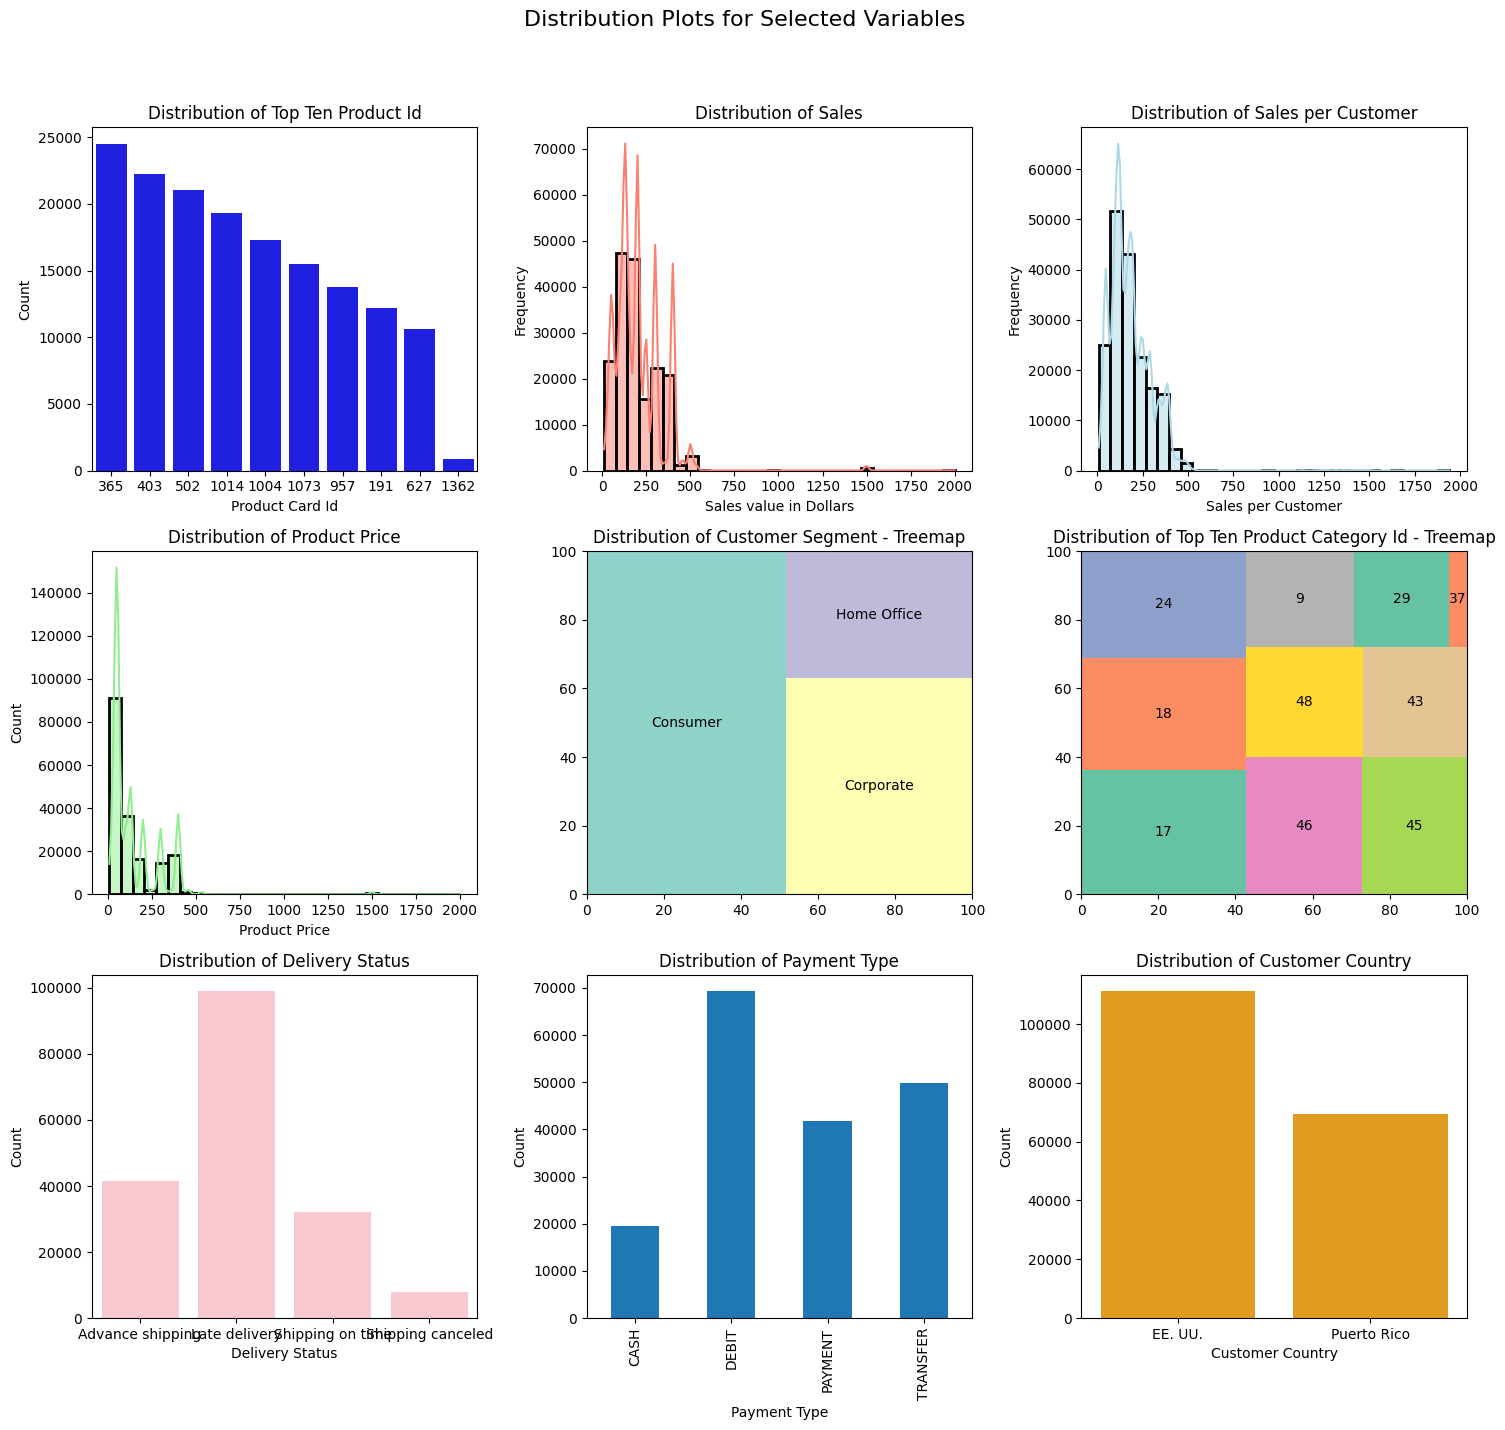

In [28]:
#| code-fold: true
#| code-summary: "Show the code"

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Distribution Plots for Selected Variables', 
             fontsize=16)
# Create a copy of the DataFrame
df_copy = df.copy()


# Plotting  the top ten products per Product Card Id
sns.countplot(data=df_copy, x='Product Card Id',
                color='blue', ax=axes[0, 0], 
                order=df_copy['Product Card Id'].value_counts().iloc[:10].index)
axes[0, 0].set_title('Distribution of Top Ten Product Id')
axes[0, 0].set_xlabel('Product Card Id')
axes[0, 0].set_ylabel('Count')


# Plotting Value of sales in  dollars
sns.histplot(data=df_copy, x='Sales', 
             kde=True, color='salmon', 
             bins=30, linewidth=2,
             ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sales')
axes[0, 1].set_xlabel('Sales value in Dollars')
axes[0, 1].set_ylabel('Frequency')


# Plotting Sales Value per customer
sns.histplot(data=df_copy, x='Sales per customer',
             bins=30, kde=True, linewidth=2,
             color='lightblue', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Sales per Customer')
axes[0, 2].set_xlabel('Sales per Customer')
axes[0, 2].set_ylabel('Frequency')

# Ploting the distribution of Product Price
sns.histplot(data=df_copy, x='Product Price', bins=30, kde=True, 
             color='lightgreen', linewidth=2, ax=axes[1, 0])

axes[1, 0].set_title('Distribution of Product Price')
axes[1, 0].set_xlabel('Product Price')

# ploting a tree map for Customer Segment
squarify.plot(sizes=df_copy['Customer Segment'].value_counts(), 
              label=df_copy['Customer Segment'].value_counts().index, 
              color=sns.color_palette("Set3"), ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Customer Segment - Treemap')

# ploting a tree map for Top Ten Product Category Id
squarify.plot(sizes=df_copy['Product Category Id'].value_counts().iloc[:10],
                label=df_copy['Product Category Id'].value_counts().iloc[:10].index,
                color=sns.color_palette("Set2"), ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Top Ten Product Category Id - Treemap')

# Plotting the distribution of Delivery Status
sns.countplot(data=df_copy, x='Delivery Status',
                color='pink', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Delivery Status')
axes[2, 0].set_xlabel('Delivery Status')
axes[2, 0].set_ylabel('Count')


# Plotting the distribution Payment Type with stacked bar chart
df_copy.groupby(['Type'])['Type'].count().plot(kind='bar', 
                                               stacked=True,
                                               ax=axes[2, 1])

axes[2, 1].set_title('Distribution of Payment Type')
axes[2, 1].set_xlabel('Payment Type')
axes[2, 1].set_ylabel('Count')

# Plotting the Distribution of top ten Customer Country
sns.countplot(data=df_copy, x='Customer Country',
                color='orange', ax=axes[2, 2], 
                order=df_copy['Customer Country'].value_counts().iloc[:10].index)
axes[2, 2].set_title('Distribution of Customer Country')
axes[2, 2].set_xlabel('Customer Country')
axes[2, 2].set_ylabel('Count')



# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plots
plt.show()


<h4>Time Series HeatMap of The Demand</h4>

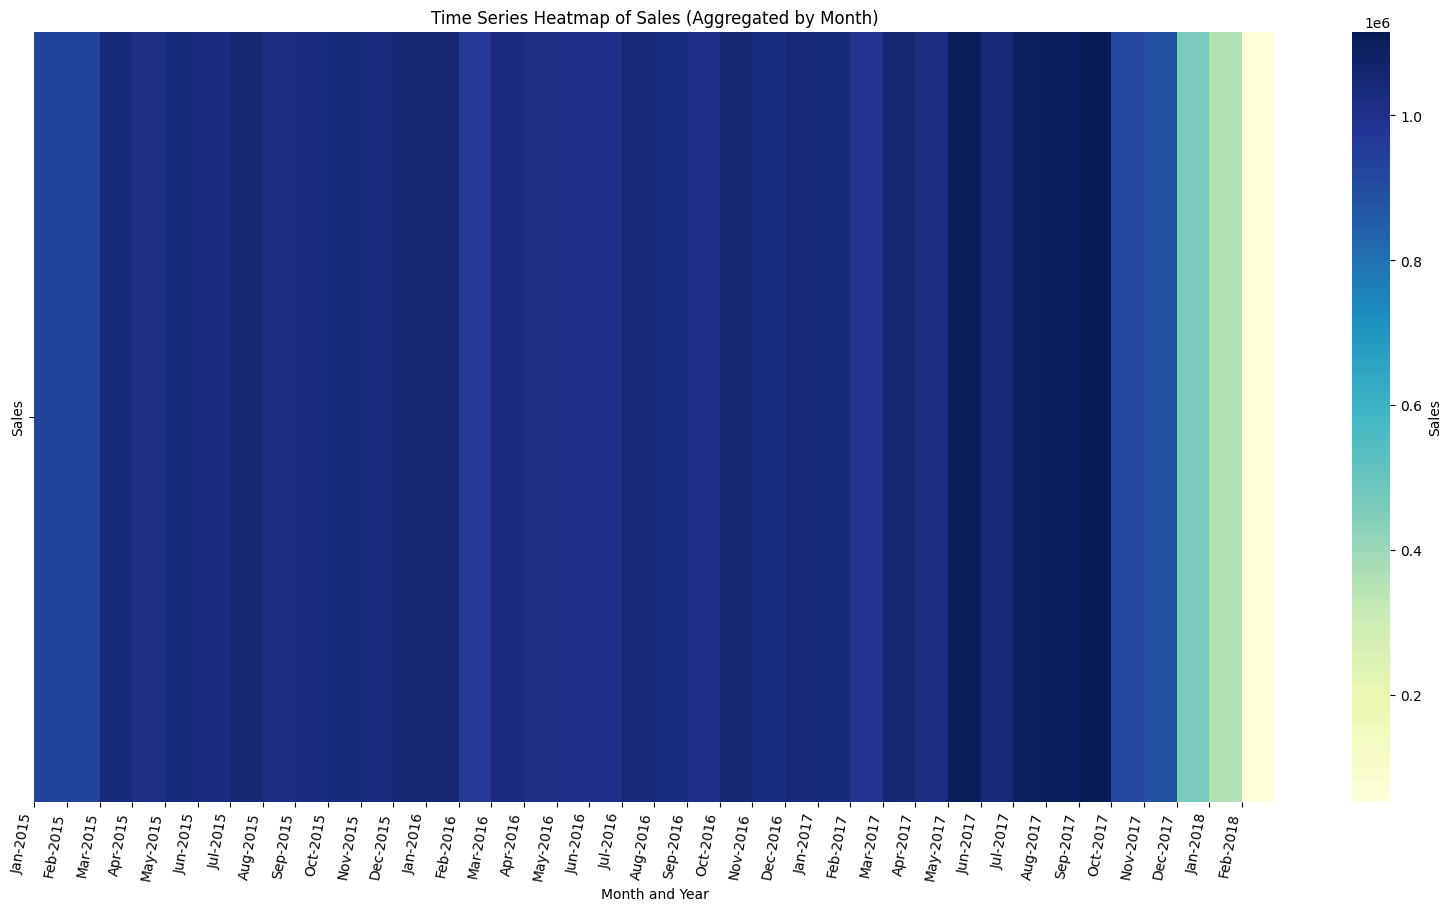

In [29]:
#| code-fold: true
#| code-summary: "Show the code"	
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# Extract shipping date (DateOrders) and Sales columns
df_heatmap = df[['shipping date (DateOrders)', 'Sales']]
# Assuming 'df' is your original dataframe

df_heatmap.set_index('shipping date (DateOrders)', inplace=True)
resampled_df = df_heatmap.resample('M').sum()  # Resample to yearly frequency
# Set x-axis ticks to represent months and years
month_labels = [calendar.month_abbr[m.month] + '-' + str(m.year) for m in resampled_df.index]
# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(resampled_df.T, cmap='YlGnBu', cbar_kws={'label': 'Sales'})
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=80, ha='right')

plt.title('Time Series Heatmap of Sales (Aggregated by Month)')
plt.xlabel('Month and Year')


plt.show()

In [30]:
#| code-fold: true
#| code-summary: "Show the code"

# import prophet
from prophet import Prophet

prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})
# Add custom Puerto Rico holidays
# Read the CSV file
holidays_df = pd.read_csv('data/puertorican_holidays.csv')

# Rename the 'Date' column to 'ds' and the 'Name' column to 'holiday'
holidays_df = holidays_df.rename(columns={'Date': 'ds', 'Name': 'holiday'})

# Drop the 'Type' column as it's not needed
holidays_df = holidays_df.drop(columns=['Type'])

# Add 'lower_window' and 'upper_window' columns
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 1

# Convert 'ds' to DateTime
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

# Create a Prophet instance and provide the holidays DataFrame
prophet = Prophet(holidays=holidays_df)

prophet.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
future = prophet.make_future_dataframe(periods=365, freq='D')

# Generate forecasts
forecast = prophet.predict(future) 

16:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:49:07 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')

  0%|          | 0/1 [00:00<?, ?it/s]

18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 900x600 with 0 Axes>

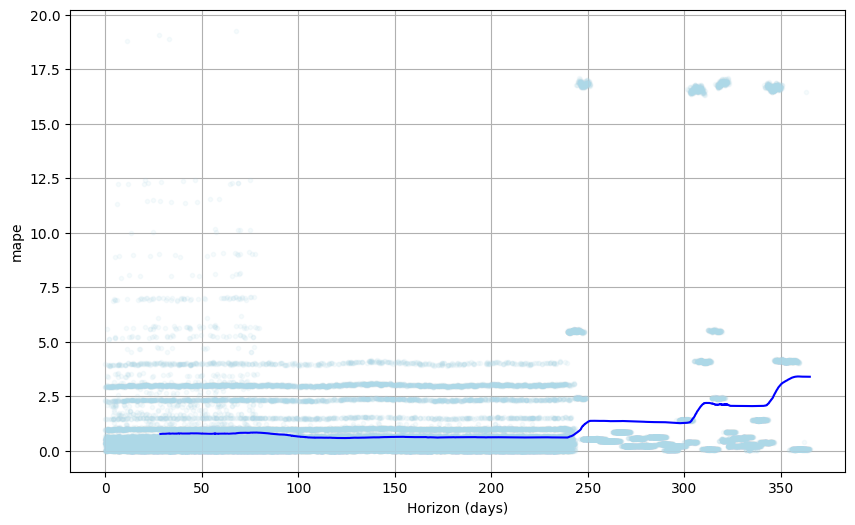

In [32]:
# Plot MAPE
from prophet.plot import plot_cross_validation_metric
#  set fig size
plt.figure(figsize=(9, 6))
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
from sklearn.model_selection import ParameterGrid

# Assuming prophet_df is your DataFrame with 'ds' and 'y' columns
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})

# Specify hyperparameter values to try
param_grid = {
    'seasonality_mode': ["additive", 'multiplicative'],
    'seasonality_prior_scale': [1, 5, 10, 20],
    'holidays_prior_scale': [5, 10, 20, 25],
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]
}

# Generate all combinations of hyperparameters using ParameterGrid
param_combinations = ParameterGrid(param_grid)

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
from itertools import product
# Store results in a dictionary
results = {}
print(f"trying all {len(param_combinations)} hyperparameter combinations")
# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

for params in param_combinations:
    # Create a Prophet instance with current hyperparameter values
    prophet = Prophet(**dict(zip(param_grid.keys(), params)))

    # Fit the model
    prophet.fit(prophet_df)

    # Perform cross-validation
    df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')


    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv, rolling_window=0)

    # Store metrics in the results dictionary
    results[params] = df_metrics['mape'].mean()


In [ ]:
# Find the hyperparameters with the lowest RMSE
best_hyperparams = min(results, key=results.get)
print(f"Best Hyperparameters: {dict(zip(param_grid.keys(), best_hyperparams))}")

<div class="cell-output cell-output-stdout">
<pre><code>Best Hyperparameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.005}</code></pre>
</div>

In [33]:
tuned_prophet = Prophet(holidays=holidays_df, 
                        seasonality_mode='additive', 
                        seasonality_prior_scale=1, 
                        holidays_prior_scale=5, 
                        changepoint_prior_scale=0.005)
# fit the model
tuned_prophet.fit(prophet_df)
# Create a DataFrame with future dates for forecasting
future = tuned_prophet.make_future_dataframe(periods=365, freq='D')

# Generate forecasts
new_forecast = tuned_prophet.predict(future)

19:27:47 - cmdstanpy - INFO - Chain [1] start processing
19:53:04 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
tuned_df_cv = cross_validation(model=tuned_prophet, initial='730 days', period='365 days', horizon='365 days')

  0%|          | 0/1 [00:00<?, ?it/s]

20:34:36 - cmdstanpy - INFO - Chain [1] start processing
20:40:55 - cmdstanpy - INFO - Chain [1] done processing


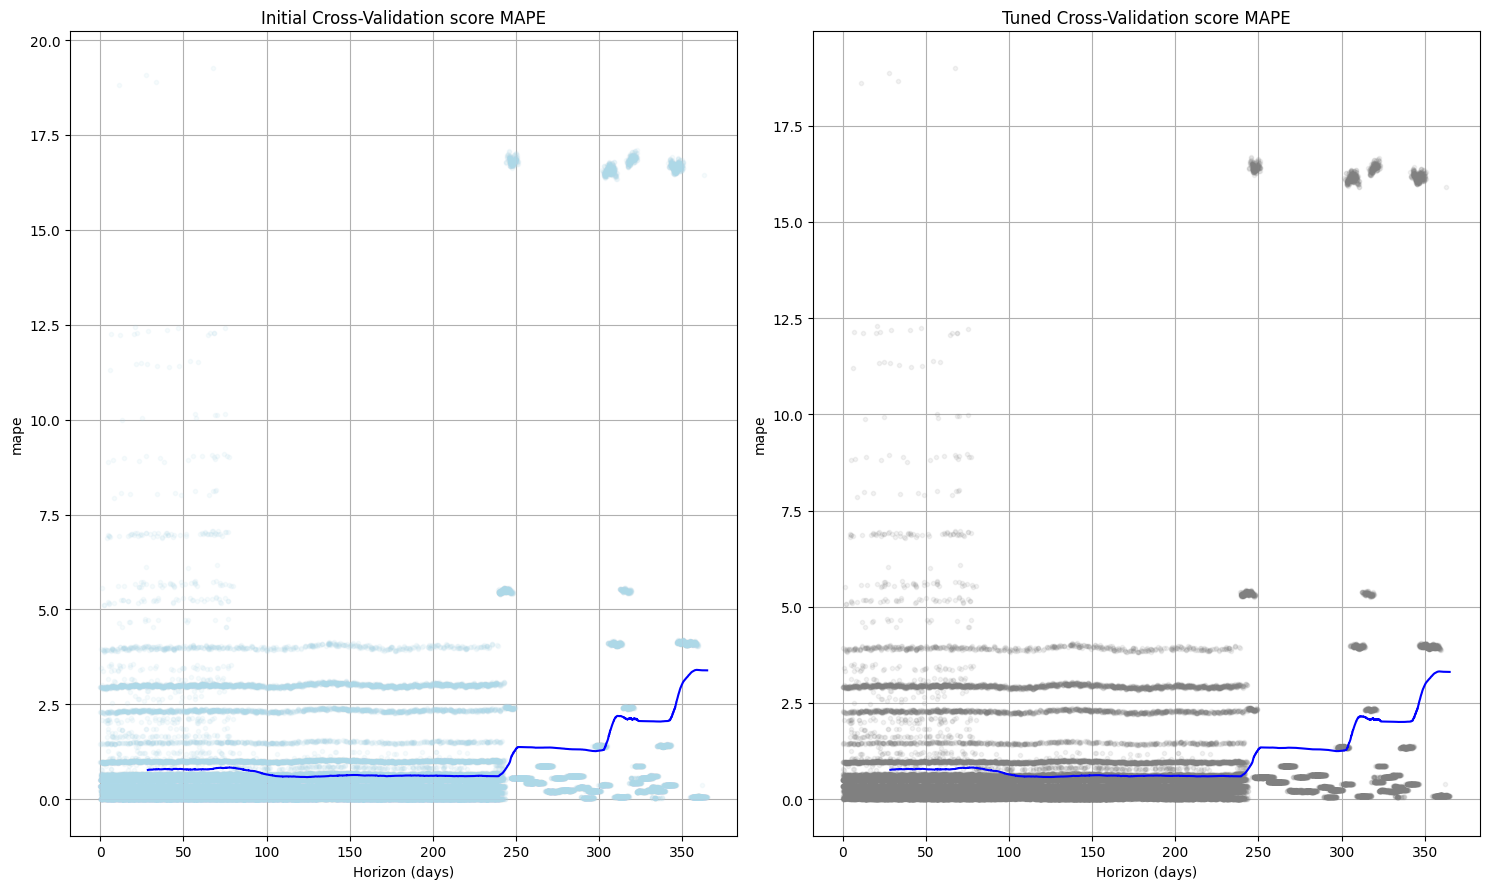

In [35]:
#| code-fold: true
#| code-summary: "Show the code"
fig, axs = plt.subplots(1, 2, figsize=(15, 9))

# Plot the first cross-validation metric
fig1 = plot_cross_validation_metric(df_cv, metric='mape', ax=axs[0])
fig1.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig1.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[0].set_title('Initial Cross-Validation score MAPE')

# Plot the second cross-validation metric
fig2 = plot_cross_validation_metric(tuned_df_cv, metric='mape', ax=axs[1])
fig2.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig2.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E9')  # Change color of the dot edges
# add title
axs[1].set_title('Tuned Cross-Validation score MAPE')

plt.tight_layout()
plt.show()

In [36]:
forecast.head(2)

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2015-01-03 00:00:00  189.503452   66.035120  371.245609   189.503452   
1 2015-01-03 03:30:00  189.646216   58.800553  399.717455   189.646216   

   trend_upper  American Citizenship Day  American Citizenship Day_lower  \
0   189.503452                       0.0                             0.0   
1   189.646216                       0.0                             0.0   

   American Citizenship Day_upper  Christmas Day  ...    weekly  weekly_lower  \
0                             0.0            0.0  ... -1.288207     -1.288207   
1                             0.0            0.0  ... -1.373629     -1.373629   

   weekly_upper     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0     -1.288207  33.801001     33.801001     33.801001                   0.0   
1     -1.373629  33.618634     33.618634     33.618634                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  220.974183  
1                         0.0                         0.0  221.460580  

[2 rows x 73 columns]

<h4 class="anchored">
Visualizing Forecasted Sales
</h4>

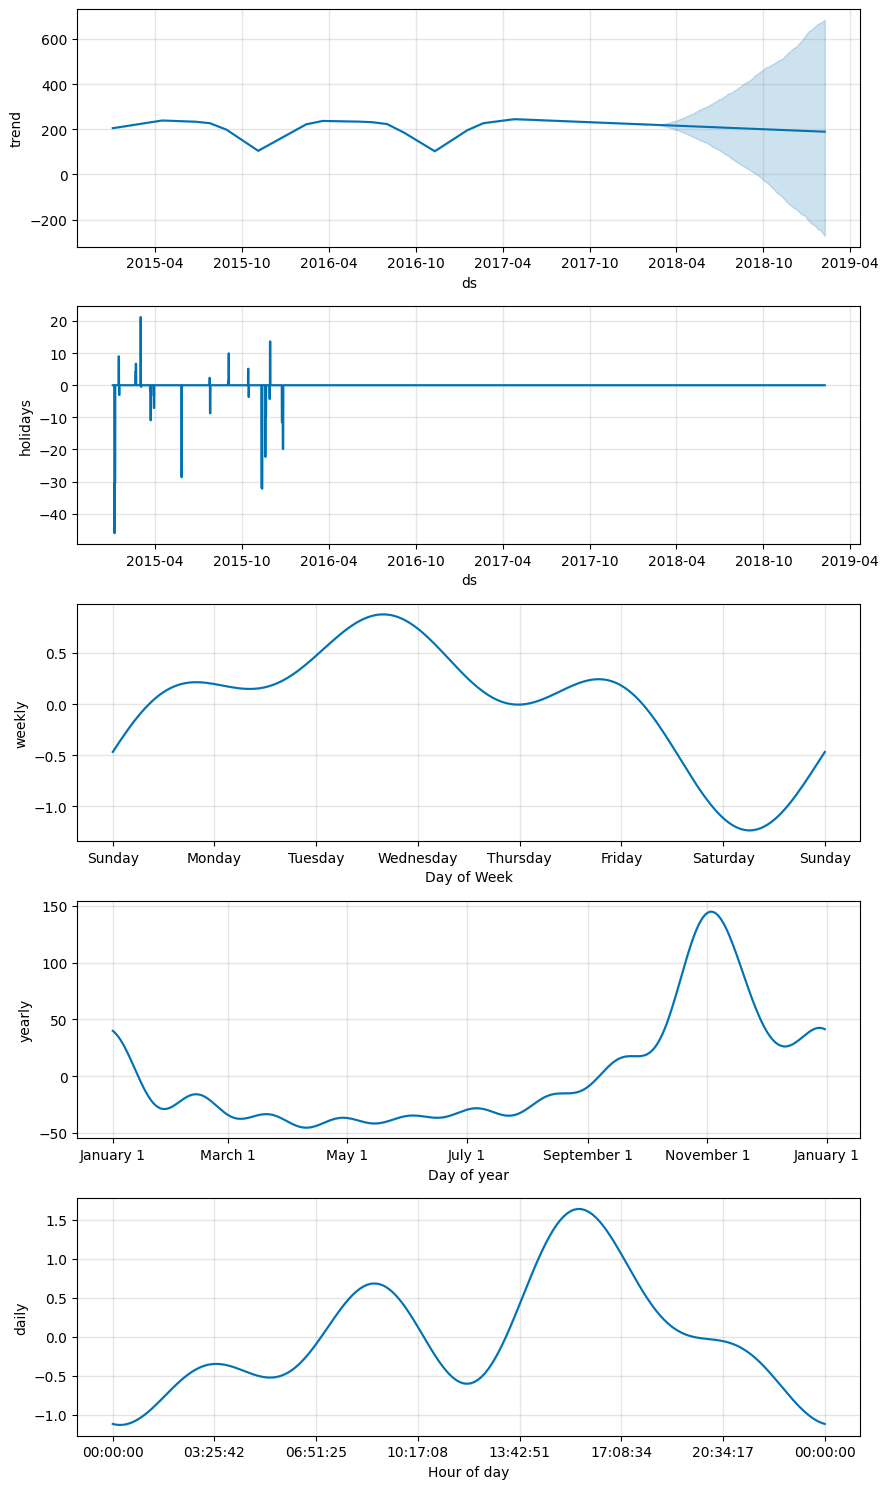

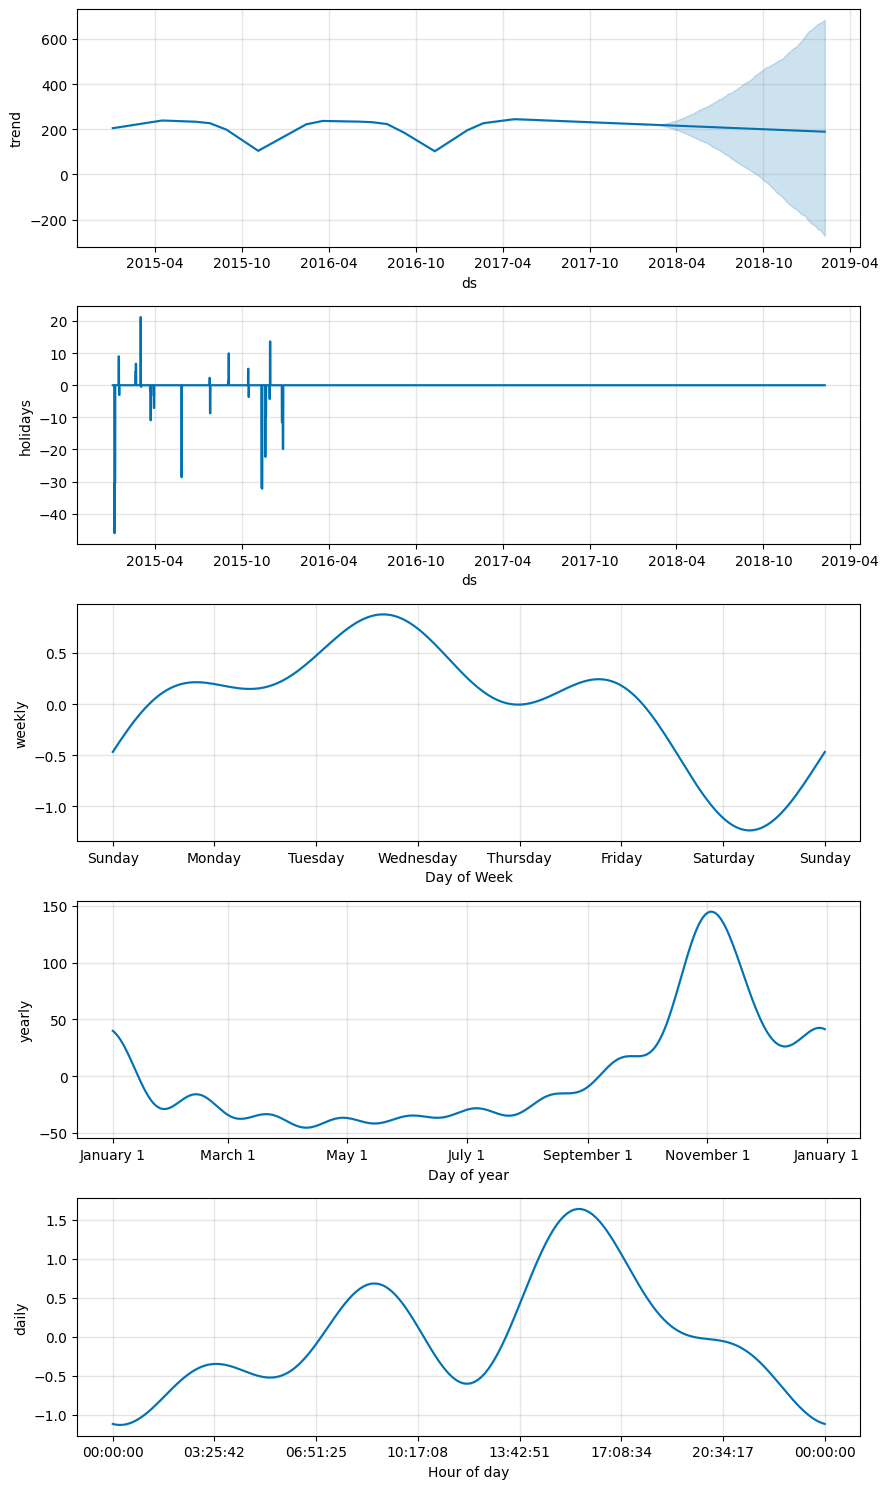

In [37]:
import warnings

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot the forecast
tuned_prophet.plot_components(new_forecast)


<h5>What is the demand forecast for the top selling product in the next 24 months?</h5>


In [38]:

# Extract average forecasted sales per day
average_forecasted_sales = new_forecast['yhat'].mean()


# Extract the average lead time
average_lead_time = 7  # 7 days
print(f"Average Lead Time: {average_lead_time}")

lead_time_demand = average_forecasted_sales * average_lead_time
print(f"Lead Time Demand: {lead_time_demand}")

Average Lead Time: 7
Lead Time Demand: 1469.1331793554164


In [39]:
# find maximum daily forecasted sales
max_daily_forecasted_sales = new_forecast['yhat'].max()
print(f"Maximum Daily Forecasted Sales: {max_daily_forecasted_sales}")

# find maximum lead time
max_lead_time = average_lead_time + 3  # 3 days delays in delivery than the average
print(f"Maximum Lead Time: {max_lead_time}")

# calculate safety stock
safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
print(f"Safety Stock: {safety_stock}")

Maximum Daily Forecasted Sales: 375.38211369017046
Maximum Lead Time: 10
Safety Stock: 2284.687957546288


In [41]:
# calculate reorder point
reorder_point = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {reorder_point}")

The Optimal Reorder Point for the Top-selling Product is: 3753.8211369017044


In [42]:
# extract the product price of top selling product(product card id:365)
product_price = df[df['Product Card Id'] == 365]['Product Price'].iloc[0]
print(f"The Product Price is: {product_price}")
# calculate holding cost
H = 0.10 * product_price
# calculate ordering cost
S = 0.30 * product_price

# calculate forecasted demand rate
D = new_forecast['yhat'].mean()

print(f"The Demand Rate is: {D}")
print(f"The Holding Cost is: {H}")
print(f"The Ordering Cost is: {S}")

The Product Price is: 59.99000168
The Demand Rate is: 209.8761684793452
The Holding Cost is: 5.999000168
The Ordering Cost is: 17.997000504


In [43]:
EOQ = math.sqrt((2 * D * S) / H)
print(f"The Economic Order Quantity is: {EOQ}")

The Economic Order Quantity is: 35.48601148165388
